In [1]:
# imports
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sym import CNN, Augment, ProgressBar
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
#transform = torchvision.transforms.Pad((280,280))
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)

In [3]:
n_digits = 1
h_digit,w_digit = (24,12)
transform = transforms.Compose([transforms.CenterCrop((h_digit,20)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data).view(-1,n_digits,h_digit,w_digit)
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1)
data = data.permute(2,1,0).unsqueeze(1)/255
targets = imagenet_data_train.targets.view(-1,n_digits)[:,:].sum(axis=1)%2
#targets = 2*targets -1 
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

In [4]:
data = transform(imagenet_data_val.data).view(-1,n_digits,h_digit,w_digit)
data = data.permute(1,3,2,0).contiguous().view(w_digit*n_digits,h_digit,-1)
data = data.permute(2,1,0).unsqueeze(1)/255
targets = imagenet_data_val.targets.view(-1,n_digits)[:,:].sum(axis=1)%2
#targets = 2*targets -1 
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),
                                          batch_size=16,
                                          shuffle=True)

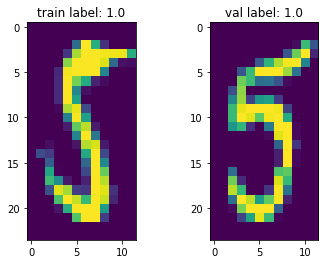

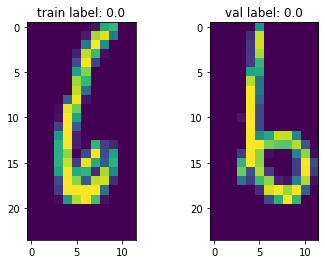

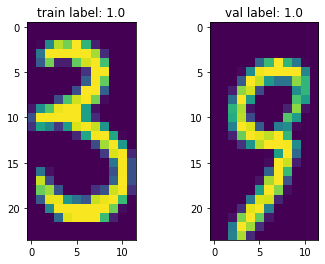

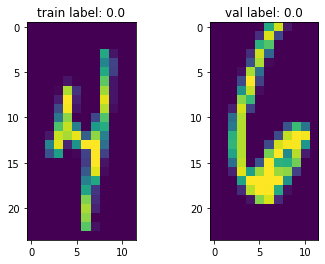

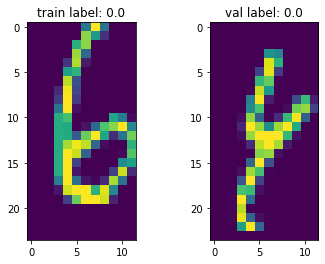

In [5]:
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x[0])
    axes[1].imshow(x2[0])
    if i==5: break

In [6]:
# Define metrics function
def metrics(model):
    with torch.no_grad():
        model.eval()
        model.to(device)
        yhat = []
        targets = []
        for x, y in valloader:
            x = x.to(device)
            yhat.append(model(x).cpu().numpy())
            targets.append(y.cpu().numpy())
    yhat = np.concatenate(yhat)
    targets = np.concatenate(targets)
    out = classification_report(targets, np.sign(yhat))
    print(out)
def plot_loss():
    plt.plot(np.arange(0, T), losses_train[0:], label="Train")
    plt.plot(np.arange(0, T, log_step), losses_val, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
nfilters = 1024
stride=1
kernel_size = 12
outdim = int(np.floor((h_digit*n_digits - kernel_size)/stride) + 1)
cnn = torch.nn.Sequential(torch.nn.Conv2d(1, nfilters, kernel_size=kernel_size, stride=stride),
#                           torch.nn.BatchNorm2d(nfilters),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool2d((10, 1)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(nfilters*outdim, 512), #(8*n_digits-24+8)
                          torch.nn.Sigmoid(),
                         )  # (10)**2
optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-3)
cnn.to(device)
cnn.train()
for i in range(10):
    batch_loss = []
    for x,y in trainloader:
        x=x.to(device)
        y=y.to(device)
        loss = torch.mean((cnn(x)-y.view(-1,1))**2)
        loss.backward()
        batch_loss.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
    print(np.mean(batch_loss))

0.023798702490582885
0.012038387661217951
0.009734411806342994


In [111]:
torch.mean((cnn(x)-y.view(-1,1))**2)

tensor(0.3258, device='cuda:0', grad_fn=<MeanBackward0>)

In [108]:
print(y)

tensor([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
       device='cuda:0')


In [107]:
print(cnn(x))

tensor([[0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802],
        [0.2802]], device='cuda:0', grad_fn=<AddmmBackward>)


In [79]:
nfilters = 1024
stride=1
outdim = int(np.floor((w_digit*n_digits - 24)/stride) + 1)
from torchsummary import summary
fcn = torch.nn.Sequential(torch.nn.Flatten(),
                          torch.nn.Linear(h_digit*w_digit*n_digits, nfilters), #* more for full fcn width
                          #torch.nn.BatchNorm1d(nfilters*(10)**2),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool1d(100,100),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, nfilters),
                          torch.nn.ReLU(),
                          torch.nn.Linear(nfilters, 1),
                          torch.nn.Sigmoid(),)
cnn = torch.nn.Sequential(torch.nn.Conv2d(1, nfilters, kernel_size=24, stride=stride),
#                           torch.nn.BatchNorm2d(nfilters),
                          torch.nn.ReLU(),
                          #torch.nn.MaxPool2d((10, 1)),
                          torch.nn.Flatten(),
                          torch.nn.Linear(nfilters*outdim, 1), #(8*n_digits-24+8)
                          torch.nn.Sigmoid(),
                         )  # (10)**2
summary(cnn.cuda(),(1,h_digit,w_digit*n_digits))
summary(fcn.cuda(),(h_digit*w_digit*n_digits,))
criterion = torch.nn.MSELoss()
#summary(cnn.cuda(),(1,24,8*5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 1024, 1, 1]         590,848
              ReLU-2           [-1, 1024, 1, 1]               0
           Flatten-3                 [-1, 1024]               0
            Linear-4                    [-1, 1]           1,025
           Sigmoid-5                    [-1, 1]               0
Total params: 591,873
Trainable params: 591,873
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.26
Estimated Total Size (MB): 2.28
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 576]               0
            Linear-2                 [-1,

# Training some models 

In [54]:
T = 30  # epochs
log_step = 1  # validate and print losses every log_steps

In [65]:
# Define training and validation functions
def train(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.train()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()
def validate(model, x, y):
    x = x.to(device)
    y = y.to(device)
    model.eval()
    with torch.no_grad():
        yhat = model(x)
        loss = criterion(yhat, y)
    return loss.item()

In [66]:
def train_loop(model, T=10, log_step=1):
    losses_train = []
    losses_val = []
    model.train()
    total_steps = len(trainloader)
    for t in range(1, T+1):
        loss = list()  # Combine losses from differetn steps in a single epoch
        # Training Step
        for step, (x, y) in enumerate(trainloader):
            loss_ = train(model, x, y)
            loss.append(loss_)
            print(
                f"Epoch {t:>03d}/{T:^3d} [Step {step+1}/{total_steps}] | Training loss: {loss_:^.4f}", end="\r")
        loss = np.mean(loss)
        losses_train.append(loss)
        # Validation Step
        if t % log_step == 0:
            message = f"Epoch {t:>03d}/{T:^3d} | Training loss: {loss:^.4f} - "
            loss = []
            with torch.no_grad():
                for x, y in valloader:
                    loss_ = validate(model, x, y)
                    loss.append(loss_)
            loss = np.mean(loss)
            losses_val.append(loss)
            message += f"Validation loss: {loss:^.4f}"
            print(message)  # ,end="\r"
    return losses_train, losses_val

#  CNN Training

In [68]:
# Train the CNN for 100 epochs
cnn.to(device)
cnn.optimizer = torch.optim.Adam(cnn.parameters(),lr=1e-5)
losses_train, losses_val = train_loop(cnn,T=T,log_step=log_step)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 001/30  | Training loss: 0.4906 - Validation loss: 1.0000


KeyboardInterrupt: 

In [15]:
cnn(xs.cuda())

tensor([[0.0053],
        [0.0050],
        [0.0048],
        [0.0055],
        [0.0018],
        [0.0036],
        [0.0080],
        [0.0056],
        [0.0070],
        [0.0055],
        [0.0062],
        [0.0002],
        [0.0067],
        [0.0049],
        [0.0129],
        [0.0091]], device='cuda:0', grad_fn=<SigmoidBackward>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


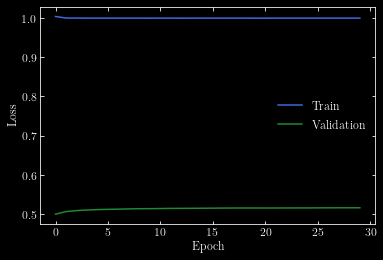

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       956
         1.0       0.52      1.00      0.69      1044

    accuracy                           0.52      2000
   macro avg       0.26      0.50      0.34      2000
weighted avg       0.27      0.52      0.36      2000



/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
plot_loss()
metrics(cnn)

# LCN Training

In [14]:
# lcn = LCN()
# lcn.to(device)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# optimizer = torch.optim.Adam(lcn.parameters(), lr=1e-2)
# losses_train, losses_val = train_loop(lcn, T=T, log_step=log_step)

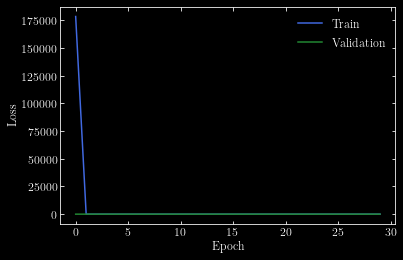

NameError: name 'lcn' is not defined

In [16]:
plot_loss()
metrics(lcn)

# FCN Training

In [80]:
fcn.to(device)
fcn.optimizer = torch.optim.SGD(fcn.parameters(), lr=1e-2)
losses_train, losses_val = train_loop(fcn, T=T, log_step=log_step)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 001/30  | Training loss: 0.2499 - Validation loss: 0.2637
Epoch 002/30  | Training loss: 0.2500 - Validation loss: 0.2572
Epoch 003/30  | Training loss: 0.2500 - Validation loss: 0.2608


KeyboardInterrupt: 

In [82]:
plot_loss()
metrics(fcn)

KeyboardInterrupt: 